In [1]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
from transformers import DeiTForImageClassification
from peft import LoraConfig, get_peft_model
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd

In [2]:
# Шлях до датасету
data_dir = r'C:\Users\Demyd Zaborskyi\.cache\kagglehub\datasets\itsahmad\indoor-scenes-cvpr-2019\versions\1\indoorCVPR_09\Images'

# Трансформації для тренувального набору
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Трансформації для валідаційного та тестового наборів
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Завантаження повного датасету
full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)

# Розділення на тренувальний, валідаційний та тестовий набори
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Застосування трансформацій до валідаційного та тестового наборів
val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform

# Параметри завантажувачів даних
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

num_classes = len(full_dataset.classes)
print(f"Number of classes: {num_classes}")

Number of classes: 67


In [3]:
# Перевірка наявності GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("No available GPU. CPU will be used for learning.")

GPU: NVIDIA GeForce RTX 4070


In [4]:
# =========================
# 1. Lora
# =========================

# Завантаження DeiT
model_lora = DeiTForImageClassification.from_pretrained('facebook/deit-base-distilled-patch16-224')

# Заміна класифікаційного шару
model_lora.classifier = nn.Linear(model_lora.classifier.in_features, num_classes)

# Налаштування LoRA без використання task_type
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none"
)

# Застосування LoRA до моделі
model_lora = get_peft_model(model_lora, lora_config)

# Замороження всіх параметрів, крім LoRA параметрів та класифікаційного шару
for name, param in model_lora.named_parameters():
    if "lora_" not in name and "classifier" not in name:
        param.requires_grad = False

# Перевірка, які параметри будуть донавчуватися
print("\nParameters of fine-tuning (LoRA):")
for name, param in model_lora.named_parameters():
    if param.requires_grad:
        print(name, param.shape)

# Переміщення моделі на пристрій
model_lora.to(device)

# Налаштування Optimizer та Критерію
criterion = nn.CrossEntropyLoss()
optimizer_lora = optim.Adam(filter(lambda p: p.requires_grad, model_lora.parameters()), lr=1e-4)


Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Parameters of fine-tuning (LoRA):
base_model.model.deit.encoder.layer.0.attention.attention.query.lora_A.default.weight torch.Size([8, 768])
base_model.model.deit.encoder.layer.0.attention.attention.query.lora_B.default.weight torch.Size([768, 8])
base_model.model.deit.encoder.layer.0.attention.attention.value.lora_A.default.weight torch.Size([8, 768])
base_model.model.deit.encoder.layer.0.attention.attention.value.lora_B.default.weight torch.Size([768, 8])
base_model.model.deit.encoder.layer.1.attention.attention.query.lora_A.default.weight torch.Size([8, 768])
base_model.model.deit.encoder.layer.1.attention.attention.query.lora_B.default.weight torch.Size([768, 8])
base_model.model.deit.encoder.layer.1.attention.attention.value.lora_A.default.weight torch.Size([8, 768])
base_model.model.deit.encoder.layer.1.attention.attention.value.lora_B.default.weight torch.Size([768, 8])
base_model.model.deit.encoder.layer.2.attention.attention.query.lora_A.default.weight torch.Size([8, 768])
ba

In [5]:
# =========================
# 2. Custom Adapter (Adapter + Multiscale)
# =========================

class DynamicMultiscaleAdapter(nn.Module):
    def __init__(self, input_dim, adapter_dim=64, scales=[1, 2, 4]):
        super(DynamicMultiscaleAdapter, self).__init__()
        self.adapters = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, adapter_dim),
                nn.ReLU(),
                nn.Linear(adapter_dim, input_dim)
            ) for _ in scales
        ])
        self.attention = nn.Linear(input_dim, len(scales))

    def forward(self, x):
        adapted = [adapter(x) for adapter in self.adapters]
        adapted_stack = torch.stack(adapted, dim=1)
        x_mean = x.mean(dim=1)
        scores = self.attention(x_mean)
        weights = torch.softmax(scores, dim=1).unsqueeze(2).unsqueeze(3)
        adapted = torch.sum(weights * adapted_stack, dim=1)
        return x + adapted

class DeiTWithCustomAdapter(nn.Module):
    def __init__(self, base_model, adapter_dim=64, scales=[1, 2, 4]):
        super(DeiTWithCustomAdapter, self).__init__()
        self.base_model = base_model
        self.num_classes = base_model.config.num_labels
        self.hidden_size = base_model.config.hidden_size

        # Додавання адаптера до кожного трансформерного блоку
        for block in self.base_model.deit.encoder.layer:
            block.adapter = DynamicMultiscaleAdapter(self.hidden_size, adapter_dim, scales)

        # Заміна класифікаційного шару
        self.base_model.classifier = nn.Linear(self.hidden_size, num_classes)

    def forward(self, pixel_values):
        outputs = self.base_model.deit(
            pixel_values=pixel_values,
            output_hidden_states=False,
            return_dict=True
        )
        x = outputs.last_hidden_state

        # Застосування адаптерів
        for block in self.base_model.deit.encoder.layer:
            x = block.adapter(x)

        x = self.base_model.deit.layernorm(x)
        pooled_output = x[:, 0]
        logits = self.base_model.classifier(pooled_output)

        return logits

# Завантаження DeiT з власним адаптером
base_deit = DeiTForImageClassification.from_pretrained('facebook/deit-base-distilled-patch16-224')
base_deit.config.num_labels = num_classes  # Встановлення правильної кількості класів
model_custom_adapter = DeiTWithCustomAdapter(base_deit, adapter_dim=64, scales=[1, 2, 4])

# Замороження основних параметрів, крім адаптерів та класифікаційного шару
for name, param in model_custom_adapter.named_parameters():
    if "adapter" not in name and "classifier" not in name:
        param.requires_grad = False

# Перевірка, які параметри будуть донавчуватися
print("\nParameters of fine-tuninng (Custom Adapter):")
for name, param in model_custom_adapter.named_parameters():
    if param.requires_grad:
        print(name, param.shape)

# Переміщення моделі на пристрій
model_custom_adapter.to(device)

# Налаштування Optimizer та Критерію
criterion_custom = nn.CrossEntropyLoss()
optimizer_custom = optim.Adam(filter(lambda p: p.requires_grad, model_custom_adapter.parameters()), lr=1e-4)

Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Parameters of fine-tuninng (Custom Adapter):
base_model.deit.encoder.layer.0.adapter.adapters.0.0.weight torch.Size([64, 768])
base_model.deit.encoder.layer.0.adapter.adapters.0.0.bias torch.Size([64])
base_model.deit.encoder.layer.0.adapter.adapters.0.2.weight torch.Size([768, 64])
base_model.deit.encoder.layer.0.adapter.adapters.0.2.bias torch.Size([768])
base_model.deit.encoder.layer.0.adapter.adapters.1.0.weight torch.Size([64, 768])
base_model.deit.encoder.layer.0.adapter.adapters.1.0.bias torch.Size([64])
base_model.deit.encoder.layer.0.adapter.adapters.1.2.weight torch.Size([768, 64])
base_model.deit.encoder.layer.0.adapter.adapters.1.2.bias torch.Size([768])
base_model.deit.encoder.layer.0.adapter.adapters.2.0.weight torch.Size([64, 768])
base_model.deit.encoder.layer.0.adapter.adapters.2.0.bias torch.Size([64])
base_model.deit.encoder.layer.0.adapter.adapters.2.2.weight torch.Size([768, 64])
base_model.deit.encoder.layer.0.adapter.adapters.2.2.bias torch.Size([768])
base_mode

In [6]:
# =========================
# 3. Adapter tuning
# =========================

class Adapter(nn.Module):
    def __init__(self, input_dim, adapter_dim=64):
        super(Adapter, self).__init__()
        self.linear_down = nn.Linear(input_dim, adapter_dim)
        self.activation = nn.ReLU()
        self.linear_up = nn.Linear(adapter_dim, input_dim)

    def forward(self, x):
        down = self.linear_down(x)
        activated = self.activation(down)
        up = self.linear_up(activated)
        return x + up  # Резідуальний зв'язок

class DeiTWithAdapters(nn.Module):
    def __init__(self, base_model, adapter_dim=64):
        super(DeiTWithAdapters, self).__init__()
        self.base_model = base_model
        self.num_classes = base_model.config.num_labels
        self.hidden_size = base_model.config.hidden_size

        # Додавання Adapter до кожного трансформерного блоку
        for block in self.base_model.deit.encoder.layer:
            block.adapter = Adapter(self.hidden_size, adapter_dim)

        # Заміна класифікаційного шару
        self.base_model.classifier = nn.Linear(self.hidden_size, self.num_classes)

    def forward(self, pixel_values):
        outputs = self.base_model.deit(
            pixel_values=pixel_values,
            output_hidden_states=False,
            return_dict=True
        )
        x = outputs.last_hidden_state

        # Застосування адаптерів
        for block in self.base_model.deit.encoder.layer:
            x = block.adapter(x)

        x = self.base_model.deit.layernorm(x)
        pooled_output = x[:, 0]
        logits = self.base_model.classifier(pooled_output)

        return logits

# Завантаження базової моделі DeiT
base_model_adapter = DeiTForImageClassification.from_pretrained('facebook/deit-base-distilled-patch16-224')
base_model_adapter.config.num_labels = num_classes  # Встановлення правильної кількості класів

# Ініціалізація моделі з Adapter Tuning
model_adapter = DeiTWithAdapters(base_model_adapter, adapter_dim=64)

# Замороження основних параметрів, крім адаптерів та класифікаційного шару
for name, param in model_adapter.named_parameters():
    if "adapter" not in name and "classifier" not in name:
        param.requires_grad = False

# Перевірка, які параметри будуть донавчуватися
print("\nParameters of fine-tuning (Adapter Tuning):")
for name, param in model_adapter.named_parameters():
    if param.requires_grad:
        print(name, param.shape)

# Переміщення моделі на пристрій
model_adapter.to(device)

# Налаштування Optimizer та Критерію
criterion_adapter = nn.CrossEntropyLoss()
optimizer_adapter = optim.Adam(filter(lambda p: p.requires_grad, model_adapter.parameters()), lr=1e-4)

Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Parameters of fine-tuning (Adapter Tuning):
base_model.deit.encoder.layer.0.adapter.linear_down.weight torch.Size([64, 768])
base_model.deit.encoder.layer.0.adapter.linear_down.bias torch.Size([64])
base_model.deit.encoder.layer.0.adapter.linear_up.weight torch.Size([768, 64])
base_model.deit.encoder.layer.0.adapter.linear_up.bias torch.Size([768])
base_model.deit.encoder.layer.1.adapter.linear_down.weight torch.Size([64, 768])
base_model.deit.encoder.layer.1.adapter.linear_down.bias torch.Size([64])
base_model.deit.encoder.layer.1.adapter.linear_up.weight torch.Size([768, 64])
base_model.deit.encoder.layer.1.adapter.linear_up.bias torch.Size([768])
base_model.deit.encoder.layer.2.adapter.linear_down.weight torch.Size([64, 768])
base_model.deit.encoder.layer.2.adapter.linear_down.bias torch.Size([64])
base_model.deit.encoder.layer.2.adapter.linear_up.weight torch.Size([768, 64])
base_model.deit.encoder.layer.2.adapter.linear_up.bias torch.Size([768])
base_model.deit.encoder.layer.3.ad

In [7]:
# =========================
# train-evaluate
# =========================

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, model_name='model'):
    best_val_acc = 0.0
    total_training_time = 0.0  # Змінна для збереження загального часу навчання

    for epoch in range(num_epochs):
        start_time = time.time()  # Початок вимірювання часу епохи

        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(pixel_values=inputs)
            logits = outputs if isinstance(outputs, torch.Tensor) else outputs.logits

            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total

        # Валідація
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(pixel_values=inputs)
                logits = outputs if isinstance(outputs, torch.Tensor) else outputs.logits

                loss = criterion(logits, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(logits, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct / val_total

        end_time = time.time()  # Кінець вимірювання часу епохи
        epoch_time = end_time - start_time
        total_training_time += epoch_time

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | "
              f"Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.4f} | "
              f"Time: {epoch_time:.2f}s")

        # Збереження найкращої моделі
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            torch.save(model.state_dict(), f'best_{model_name}.pth')

    print(f"Best Validation Accuracy for {model_name}: {best_val_acc:.4f}")
    print(f"Total Training Time for {model_name}: {total_training_time:.2f}s")
    return total_training_time  # Повертаємо час навчання

def evaluate_model(model, test_loader, device, class_names, model_name='model'):
    model.eval()
    all_preds = []
    all_labels = []
    inference_times = []  # Список для збереження часу інференції

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            start_time = time.time()  # Початок вимірювання часу інференції
            outputs = model(pixel_values=inputs)
            end_time = time.time()  # Кінець вимірювання часу інференції

            logits = outputs if isinstance(outputs, torch.Tensor) else outputs.logits

            _, preds = torch.max(logits, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            inference_times.append(end_time - start_time)

    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    avg_inference_time = sum(inference_times) / len(inference_times)

    print(f"\nTest Metrics for {model_name}:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Average Inference Time per Batch: {avg_inference_time:.4f}s")

    # Матриця сплутаності
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    return acc, precision, recall, f1, avg_inference_time, cm

def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

# Навчання моделей

In [8]:
# Навчання моделі з LoRA
print("\n=== Learning with LoRA ===")
training_time_lora = train_model(
    model=model_lora,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer_lora,
    device=device,
    num_epochs=10,
    model_name='model_lora'
)


=== Learning with LoRA ===


C:\Anaconda\envs\cuda_test\lib\site-packages\transformers\models\deit\modeling_deit.py:275: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  context_layer = torch.nn.functional.scaled_dot_product_attention(


Epoch 1/10 | Train Loss: 3.4977 | Train Acc: 0.2005 | Val Loss: 2.6205 | Val Acc: 0.3935 | Time: 91.33s
Epoch 2/10 | Train Loss: 2.1882 | Train Acc: 0.4863 | Val Loss: 1.9318 | Val Acc: 0.5425 | Time: 90.93s
Epoch 3/10 | Train Loss: 1.6648 | Train Acc: 0.6060 | Val Loss: 1.5913 | Val Acc: 0.5933 | Time: 92.06s
Epoch 4/10 | Train Loss: 1.3872 | Train Acc: 0.6723 | Val Loss: 1.4325 | Val Acc: 0.6402 | Time: 90.90s
Epoch 5/10 | Train Loss: 1.2044 | Train Acc: 0.7175 | Val Loss: 1.2917 | Val Acc: 0.6795 | Time: 91.12s
Epoch 6/10 | Train Loss: 1.0687 | Train Acc: 0.7557 | Val Loss: 1.2158 | Val Acc: 0.6978 | Time: 93.48s
Epoch 7/10 | Train Loss: 0.9623 | Train Acc: 0.7818 | Val Loss: 1.1280 | Val Acc: 0.7166 | Time: 92.52s
Epoch 8/10 | Train Loss: 0.8792 | Train Acc: 0.8044 | Val Loss: 1.1093 | Val Acc: 0.7226 | Time: 92.97s
Epoch 9/10 | Train Loss: 0.8109 | Train Acc: 0.8210 | Val Loss: 1.0445 | Val Acc: 0.7307 | Time: 91.56s
Epoch 10/10 | Train Loss: 0.7498 | Train Acc: 0.8393 | Val Loss:

In [9]:
class_names = full_dataset.classes


=== Оцінка моделі з LoRA ===

Test Metrics for LoRA:
Accuracy: 0.7636
Precision: 0.7678
Recall: 0.7636
F1-Score: 0.7552
Average Inference Time per Batch: 0.0066s


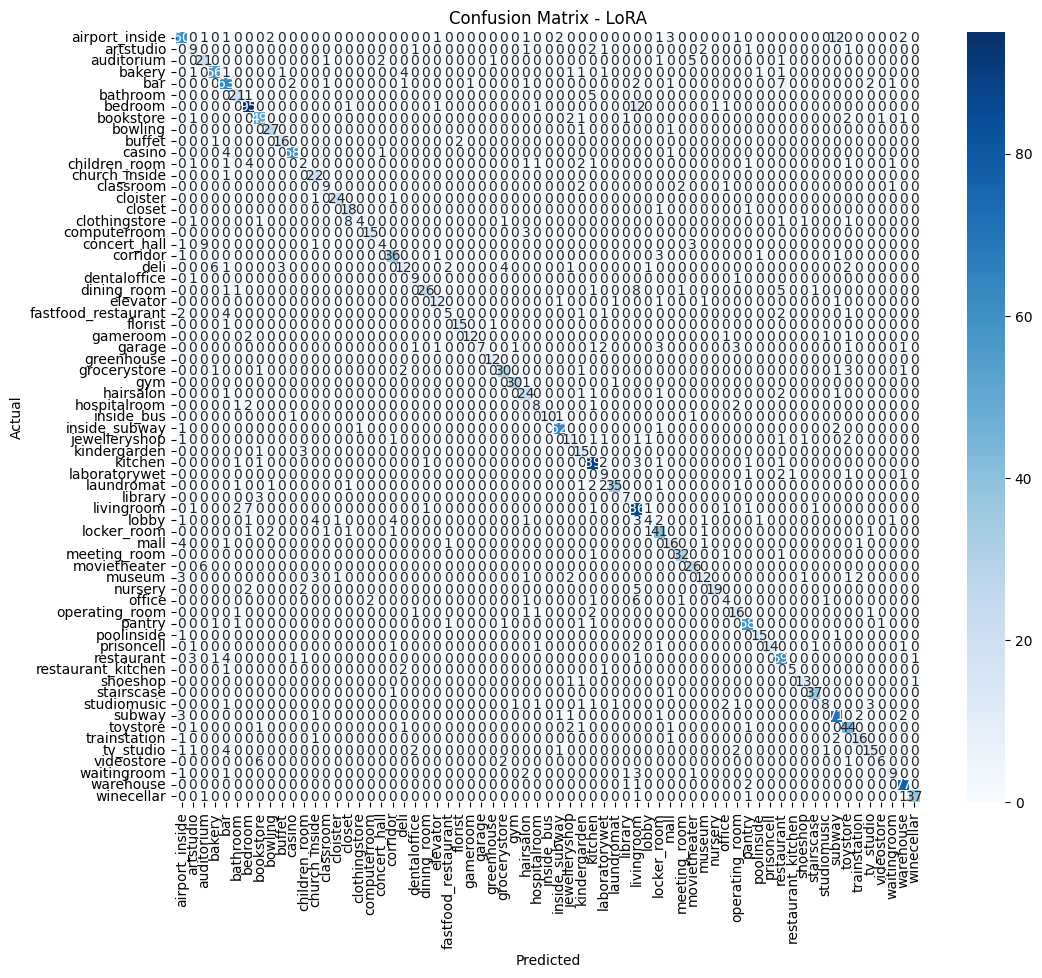

In [10]:
# Оцінка моделі з LoRA
print("\n=== LoRA evaluation ===")
model_lora.load_state_dict(torch.load('best_model_lora.pth'))
model_lora.to(device)
acc_lora, precision_lora, recall_lora, f1_lora, inference_time_lora, cm_lora = evaluate_model(
    model=model_lora,
    test_loader=test_loader,
    device=device,
    class_names=class_names,
    model_name='LoRA'
)

In [11]:
# Підрахунок параметрів моделі з LoRA
total_params_lora, trainable_params_lora = count_parameters(model_lora)
print(f"\nLoRA Model - Total Parameters: {total_params_lora}, Trainable Parameters: {trainable_params_lora}")


LoRA Model - Total Parameters: 86146627, Trainable Parameters: 294912


In [12]:
# Навчання моделі з Custom Adapter
print("\n=== Learning with Custom Adapter ===")
training_time_custom_adapter = train_model(
    model=model_custom_adapter,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion_custom,
    optimizer=optimizer_custom,
    device=device,
    num_epochs=15,
    model_name='model_custom_adapter'
)


=== Learning with Custom Adapter ===
Epoch 1/15 | Train Loss: 1.4708 | Train Acc: 0.6406 | Val Loss: 0.8361 | Val Acc: 0.7618 | Time: 65.41s
Epoch 2/15 | Train Loss: 0.5358 | Train Acc: 0.8485 | Val Loss: 0.6984 | Val Acc: 0.8045 | Time: 65.34s
Epoch 3/15 | Train Loss: 0.3350 | Train Acc: 0.9074 | Val Loss: 0.6583 | Val Acc: 0.8062 | Time: 65.30s
Epoch 4/15 | Train Loss: 0.2037 | Train Acc: 0.9504 | Val Loss: 0.6601 | Val Acc: 0.8092 | Time: 65.23s
Epoch 5/15 | Train Loss: 0.1185 | Train Acc: 0.9767 | Val Loss: 0.6739 | Val Acc: 0.8050 | Time: 65.49s
Epoch 6/15 | Train Loss: 0.0719 | Train Acc: 0.9887 | Val Loss: 0.6986 | Val Acc: 0.8088 | Time: 65.37s
Epoch 7/15 | Train Loss: 0.0410 | Train Acc: 0.9952 | Val Loss: 0.7412 | Val Acc: 0.8067 | Time: 68.01s
Epoch 8/15 | Train Loss: 0.0316 | Train Acc: 0.9952 | Val Loss: 0.7283 | Val Acc: 0.8143 | Time: 67.35s
Epoch 9/15 | Train Loss: 0.0210 | Train Acc: 0.9973 | Val Loss: 0.7566 | Val Acc: 0.8152 | Time: 69.18s
Epoch 10/15 | Train Loss: 


=== Custom Adapter evaluation ===

Test Metrics for Custom Adapter:
Accuracy: 0.8199
Precision: 0.8257
Recall: 0.8199
F1-Score: 0.8192
Average Inference Time per Batch: 0.0080s


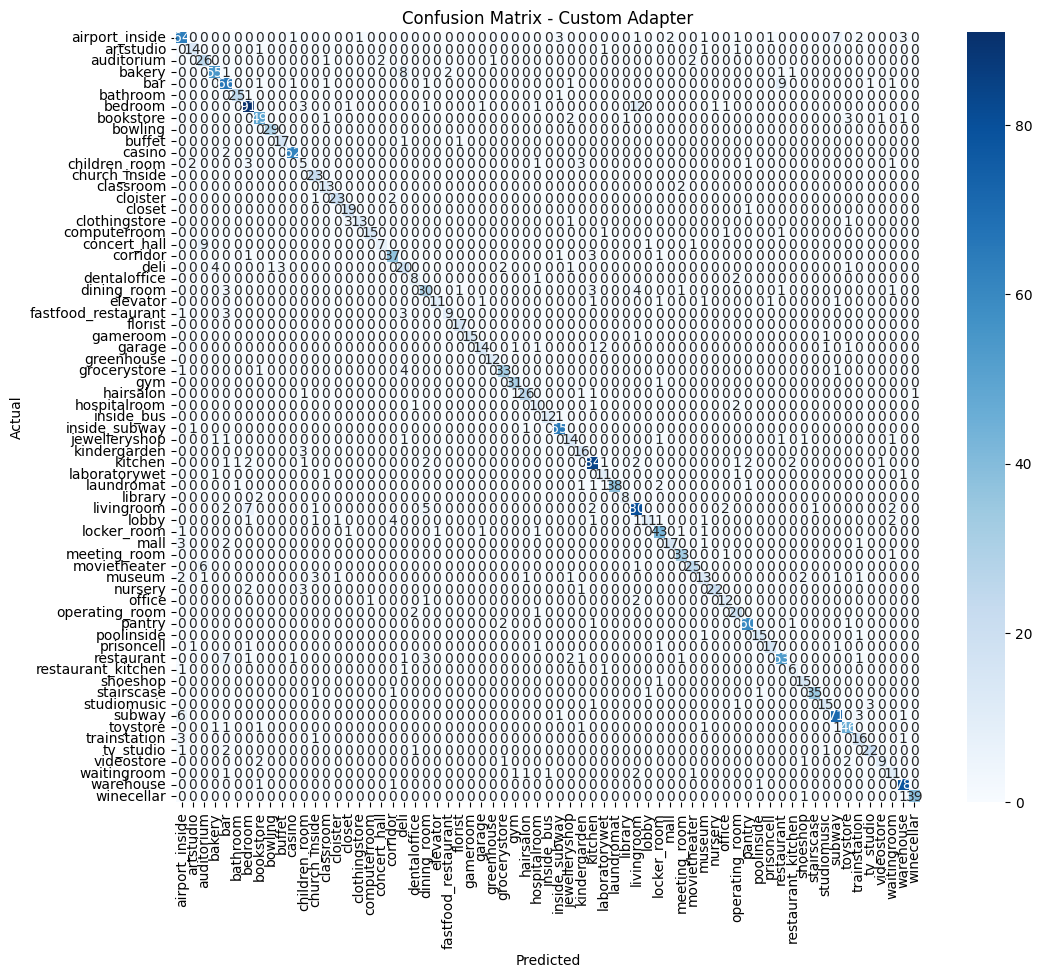

In [13]:
# Оцінка моделі з Custom Adapter
print("\n=== Custom Adapter evaluation ===")
model_custom_adapter.load_state_dict(torch.load('best_model_custom_adapter.pth'))
model_custom_adapter.to(device)
acc_custom_adapter, precision_custom_adapter, recall_custom_adapter, f1_custom_adapter, inference_time_custom_adapter, cm_custom_adapter = evaluate_model(
    model=model_custom_adapter,
    test_loader=test_loader,
    device=device,
    class_names=class_names,
    model_name='Custom Adapter'
)

In [14]:
# Підрахунок параметрів моделі з Custom Adapter
total_params_custom_adapter, trainable_params_custom_adapter = count_parameters(model_custom_adapter)
print(f"\nCustom Adapter Model - Total Parameters: {total_params_custom_adapter}, Trainable Parameters: {trainable_params_custom_adapter}")


Custom Adapter Model - Total Parameters: 89448295, Trainable Parameters: 3648103


In [15]:
# Навчання моделі з Adapter Tuning
print("\n=== Learning with Adapter Tuning ===")
training_time_adapter = train_model(
    model=model_adapter,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion_adapter,
    optimizer=optimizer_adapter,
    device=device,
    num_epochs=10,
    model_name='model_adapter'
)


=== Навчання моделі з Adapter Tuning ===
Epoch 1/10 | Train Loss: 1.5852 | Train Acc: 0.6160 | Val Loss: 0.8888 | Val Acc: 0.7473 | Time: 56.01s
Epoch 2/10 | Train Loss: 0.5956 | Train Acc: 0.8276 | Val Loss: 0.7550 | Val Acc: 0.7776 | Time: 53.13s
Epoch 3/10 | Train Loss: 0.3886 | Train Acc: 0.8899 | Val Loss: 0.7047 | Val Acc: 0.7836 | Time: 53.55s
Epoch 4/10 | Train Loss: 0.2509 | Train Acc: 0.9352 | Val Loss: 0.7171 | Val Acc: 0.7857 | Time: 54.44s
Epoch 5/10 | Train Loss: 0.1571 | Train Acc: 0.9636 | Val Loss: 0.7174 | Val Acc: 0.7930 | Time: 54.16s
Epoch 6/10 | Train Loss: 0.0979 | Train Acc: 0.9825 | Val Loss: 0.7380 | Val Acc: 0.7900 | Time: 54.48s
Epoch 7/10 | Train Loss: 0.0598 | Train Acc: 0.9920 | Val Loss: 0.7595 | Val Acc: 0.7883 | Time: 55.86s
Epoch 8/10 | Train Loss: 0.0388 | Train Acc: 0.9952 | Val Loss: 0.8015 | Val Acc: 0.7909 | Time: 53.26s
Epoch 9/10 | Train Loss: 0.0297 | Train Acc: 0.9961 | Val Loss: 0.8288 | Val Acc: 0.7887 | Time: 53.12s
Epoch 10/10 | Train Lo


=== Adapter Tuning evaluation ===

Test Metrics for Adapter Tuning:
Accuracy: 0.8079
Precision: 0.8156
Recall: 0.8079
F1-Score: 0.8073
Average Inference Time per Batch: 0.0054s


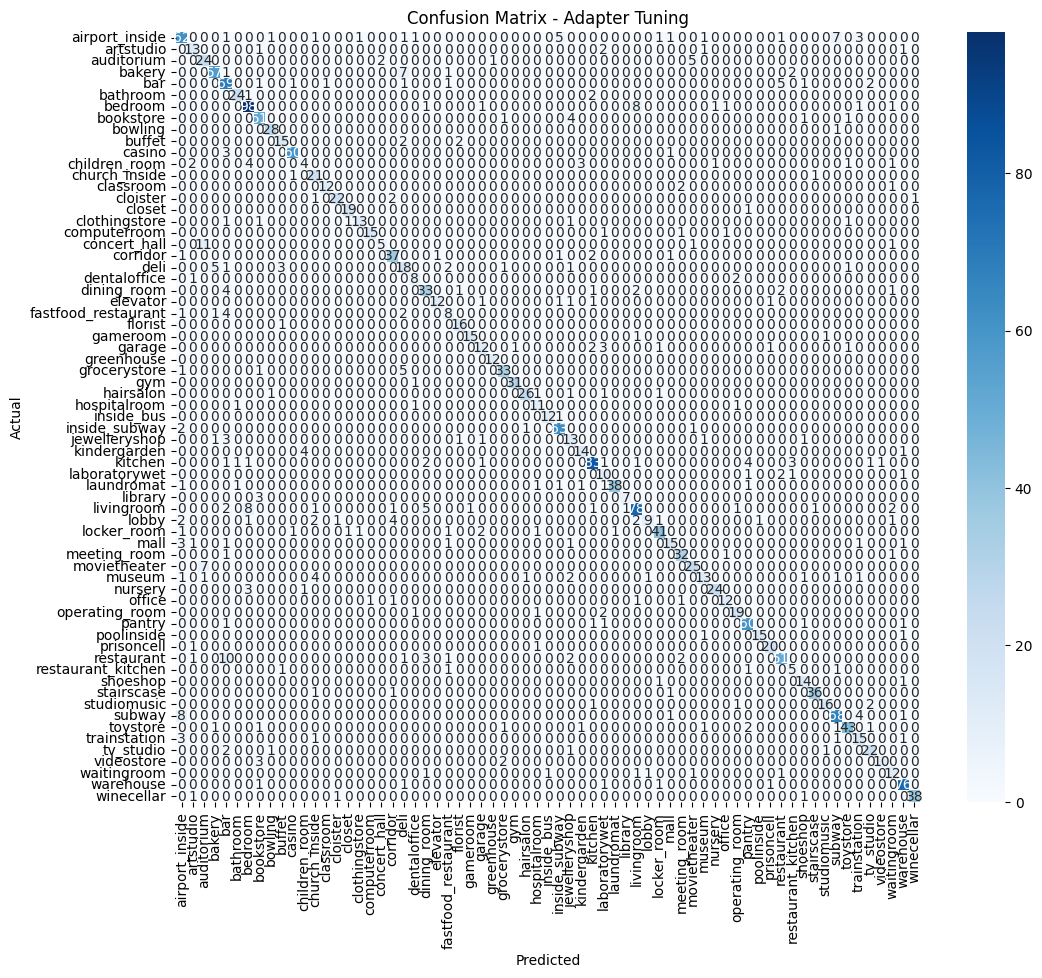

In [17]:
# Оцінка моделі з Adapter Tuning
print("\n=== Adapter Tuning evaluation ===")
model_adapter.load_state_dict(torch.load('best_model_adapter.pth'))
model_adapter.to(device)
acc_adapter, precision_adapter, recall_adapter, f1_adapter, inference_time_adapter, cm_adapter = evaluate_model(
    model=model_adapter,
    test_loader=test_loader,
    device=device,
    class_names=class_names,
    model_name='Adapter Tuning'
)

In [18]:
# Підрахунок параметрів моделі з Adapter Tuning
total_params_adapter, trainable_params_adapter = count_parameters(model_adapter)
print(f"\nAdapter Tuning Model - Total Parameters: {total_params_adapter}, Trainable Parameters: {trainable_params_adapter}")



Adapter Tuning Model - Total Parameters: 87041347, Trainable Parameters: 1241155


In [19]:
# Створення зведеної таблиці з результатами
data = {
    'Model': ['LoRA', 'Custom Adapter', 'Adapter Tuning'],
    'Accuracy': [acc_lora, acc_custom_adapter, acc_adapter],
    'Precision': [precision_lora, precision_custom_adapter, precision_adapter],
    'Recall': [recall_lora, recall_custom_adapter, recall_adapter],
    'F1-Score': [f1_lora, f1_custom_adapter, f1_adapter],
    'Training Time (s)': [training_time_lora, training_time_custom_adapter, training_time_adapter],
    'Inference Time (s)': [inference_time_lora, inference_time_custom_adapter, inference_time_adapter],
    'Total Params': [total_params_lora, total_params_custom_adapter, total_params_adapter],
    'Trainable Params': [trainable_params_lora, trainable_params_custom_adapter, trainable_params_adapter],
}

In [20]:
df_results = pd.DataFrame(data)
print("\nPEFT comparative analysis:")
print(df_results)


PEFT comparative analysis:
            Model  Accuracy  Precision    Recall  F1-Score  Training Time (s)  \
0            LoRA  0.763551   0.767820  0.763551  0.755250         918.154724   
1  Custom Adapter  0.819889   0.825741  0.819889  0.819199         997.871250   
2  Adapter Tuning  0.807939   0.815563  0.807939  0.807285         541.748332   

   Inference Time (s)  Total Params  Trainable Params  
0            0.006565      86146627            294912  
1            0.007998      89448295           3648103  
2            0.005372      87041347           1241155  


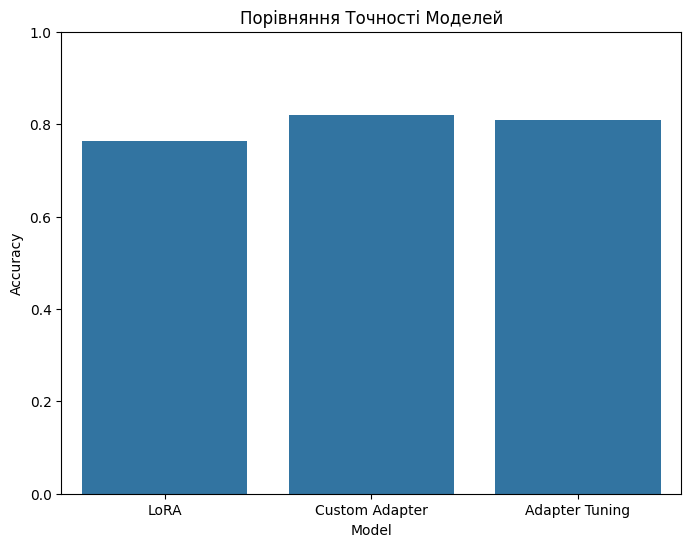

In [21]:
# Порівняння Точності
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='Accuracy', data=df_results)
plt.title('Порівняння Точності Моделей')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

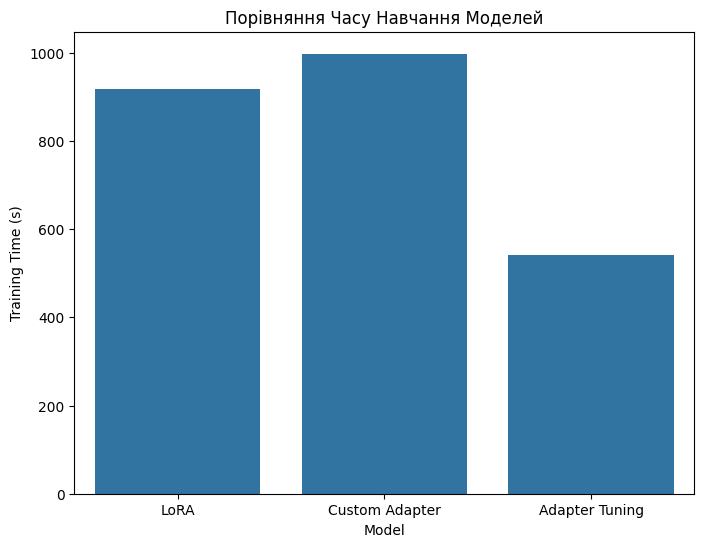

In [22]:
# Порівняння Часу Навчання
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='Training Time (s)', data=df_results)
plt.title('Порівняння Часу Навчання Моделей')
plt.ylabel('Training Time (s)')
plt.show()

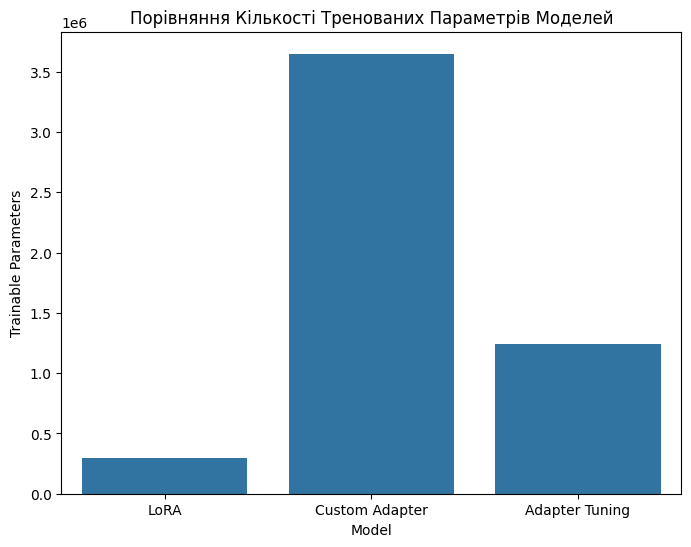

In [23]:
# Порівняння Кількості Тренованих Параметрів
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='Trainable Params', data=df_results)
plt.title('Порівняння Кількості Тренованих Параметрів Моделей')
plt.ylabel('Trainable Parameters')
plt.show()